In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image

Training set - Benign: 1440, Malignant: 1197
Test set - Benign: 360, Malignant: 300


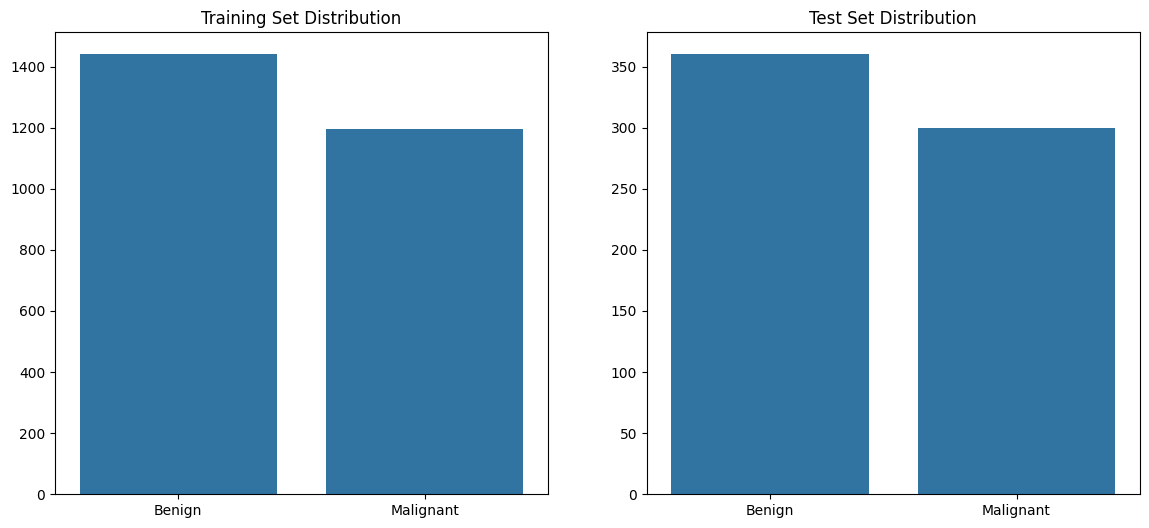

In [2]:
# Path to the dataset
data_dir = 'skin cancer data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Count the number of images in each class in the training and test sets
def count_images(directory):
    benign_count = len(os.listdir(os.path.join(directory, 'benign')))
    malignant_count = len(os.listdir(os.path.join(directory, 'malignant')))
    return benign_count, malignant_count

train_benign, train_malignant = count_images(train_dir)
test_benign, test_malignant = count_images(test_dir)

print(f"Training set - Benign: {train_benign}, Malignant: {train_malignant}")
print(f"Test set - Benign: {test_benign}, Malignant: {test_malignant}")

# Plot the distribution
labels = ['Benign', 'Malignant']
train_counts = [train_benign, train_malignant]
test_counts = [test_benign, test_malignant]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=labels, y=train_counts, ax=axes[0])
axes[0].set_title('Training Set Distribution')
sns.barplot(x=labels, y=test_counts, ax=axes[1])
axes[1].set_title('Test Set Distribution')
plt.show()


In [3]:
# Image data generators for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory for training, validation and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [4]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\Asmat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10)


Epoch 1/10


c:\Users\Asmat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 221ms/step - accuracy: 0.6211 - loss: 0.6328 - val_accuracy: 0.7559 - val_loss: 0.5452
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.4835 - val_accuracy: 0.8000 - val_loss: 0.3893
Epoch 3/10


c:\Users\Asmat\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.7854 - loss: 0.4532 - val_accuracy: 0.7695 - val_loss: 0.4779
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.7812 - loss: 0.3879 - val_accuracy: 0.6667 - val_loss: 0.7345
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.7960 - loss: 0.4234 - val_accuracy: 0.7285 - val_loss: 0.5398
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.7500 - loss: 0.5039 - val_accuracy: 0.6667 - val_loss: 0.4694
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.7919 - loss: 0.4496 - val_accuracy: 0.7598 - val_loss: 0.4933
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.3857 - val_accuracy: 0.7333 - val_loss: 0.3804
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.8108 - loss: 0.3936 - val_accuracy: 0.7793 - val_loss: 0.4946
Epoch 10/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.8750 - loss: 0.4039 - val_accuracy: 0.5333 - v

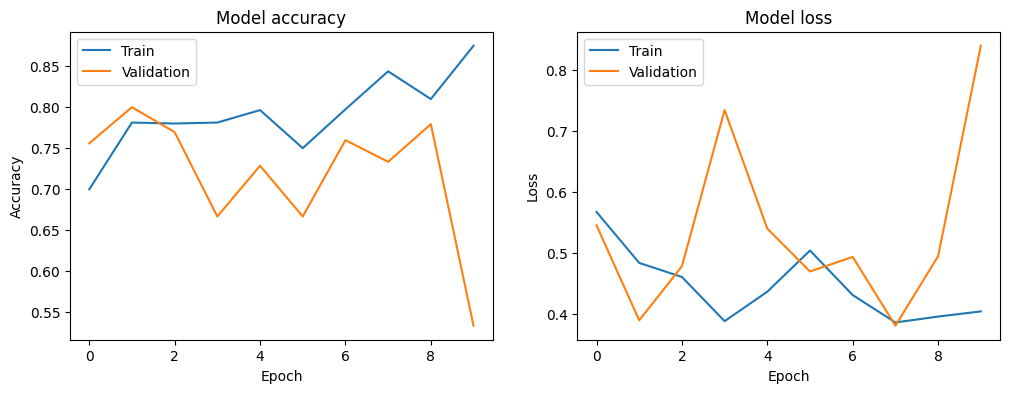

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.7937 - loss: 0.4591
Test accuracy: 77.88%
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step
Confusion Matrix
[[130 230]
 [100 200]]
Classification Report
              precision    recall  f1-score   support

      Benign       0.57      0.36      0.44       360
   Malignant       0.47      0.67      0.55       300

    accuracy                           0.50       660
   macro avg       0.52      0.51      0.49       660
weighted avg       0.52      0.50      0.49       660



In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred).astype(int).reshape(-1)
y_true = test_generator.classes

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))


In [9]:
def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Malignant"
    else:
        return "Benign"

# Example usage
image_path = r'C:\Users\Asmat\OneDrive\Desktop\ML Project\skin cancer data\test\benign\8.jpg'
result = predict_image(image_path, model)
print(f"The predicted class for the image is: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
The predicted class for the image is: Benign
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
The predicted class for the image is: Benign


In [12]:
model.save('skin_cancer_model.h5')